In [1]:
!pip install -q graphlearning annoy

     |████████████████████████████████| 69 kB 3.0 MB/s 
     |████████████████████████████████| 646 kB 8.9 MB/s 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd /content/drive/MyDrive

/content/drive/MyDrive


In [15]:
import graphlearning.active_learning as al
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import time
import timeit
import os, glob

#SKLearn imports
import sklearn.datasets as datasets
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster._kmeans import _kmeans_plusplus
from sklearn.utils import check_random_state
from sklearn.preprocessing import normalize
from sklearn.datasets import make_blobs

#Scipy imports
from scipy.linalg import sqrtm
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import eigs
import scipy.sparse as sparse
from scipy.optimize import fsolve
from scipy import spatial

# K-means batch active learning
We are considering functions like
$$\mathcal{A}(y_1, ..., y_C) =  \sum_{i=1}^n \sum_{j=1}^C P_{ij} d(x_i, y_j)^2 $$
where
$$P_{ij} = \left(1 - \frac{\mathcal{A}(x_i) \mathcal{A}(y_j)}{\max_{x, y} \mathcal{A}(x) \mathcal{A}(y)}\right) \chi_{x_i \in C(y_j)}$$
A more general framework could consider
$$P_{ij} = 1 - \frac{\phi(x_i) \mathcal{A}(y_j)}{\max_{x, y} \phi(x) \mathcal{A}(y)}$$
This $\varphi$ should not be constant on clusters so that we can break the symmetry and get a gradient descent proceedure. 
**Confirm that the notation is correct here**

This document will use SGD (or ADAM/RMSProp) to optimize this k-means acquisition function. **Not currently implemented**

## Numpy distance functions
$$ \text{Cosine Similarity}(x, y) = \arccos\left(\frac{x\cdot y}{|x|\ |y|}\right)$$

$$ \nabla_y \text{Cosine Similarity}(x, y) = \frac{1}{\sqrt{1-\cos(\theta)^2}} \left(\frac{\cos(\theta)y}{|y|^2} - \frac{x}{|x|\ |y|}\right)$$
where 
$$\cos(\theta) = \frac{x\cdot y}{|x|\ |y|}$$

For the Euclidean case, we get
$$\nabla_y |x-y| = \frac{y-x}{|y-x|}$$

When minimizing the functional, we get
$$\nabla_{y_m} \mathcal{A}(y_1, ..., y_C) = \sum_{i=1}^n P_{im} d(x_i, y_m) \nabla_y d(x_i, y_m)$$
$$ \text{Euclidean} \rightarrow \sum_{i=1}^n P_{im} |x_i-y_m| \frac{y_m-x_i}{|y_m-x_i|} = \left(\mathbb{1}^T P^{(m)}\right) y_m - X^T P^{(m)} $$
$$ \text{Cos Sim} \rightarrow \sum_{i=1}^n P_{im} \theta_{im} \frac{1}{\sqrt{1-\cos(\theta_{im})^2}} \left(\frac{\cos(\theta_{im})y_m}{|y_m|^2} - \frac{x_i}{|x_i|\ |y_m|}\right)$$
$$ = \mathbb{1}^T \left(\frac{P \theta}{\tan(\theta)}\right)^{(m)}\frac{y_m}{|y_m|^2} - \hat{X}.T \left(\frac{P \theta}{\sin(\theta)}\right)^{(m)}\frac{1}{|y_m|}$$

where $X$ is the data stored in rows and $P$ is the weight matrix we construct (based on acquisition function). Note that we use the hadamard product in $P\theta / \tan(\theta)$ and $P\theta / \sin(\theta)$. Also $\theta_{im}$ is the cosine similarity of $x_i$ and $y_m$. The matrix $\hat X$ is the normalized data. 

As can be seen by the last expressions, these can be quickly computed with numpy operations. 




$$ \sum_{i=1}^n P_{im} \theta_{im} \frac{1}{\sqrt{1-\cos(\theta_{im})^2}} \left(\frac{\cos(\theta_{im})y_m}{|y_m|^2} - \frac{x_i}{|x_i|\ |y_m|}\right)$$

$$ = \mathbb{1}^T \left(\frac{P \theta}{\tan(\theta)}\right)^{(m)}\frac{y_m}{|y_m|^2} - \hat{X} \left(\frac{P \theta}{\sin(\theta)}\right)^{(m)}\frac{1}{|y_m|}$$

# Bal Functions

In [16]:
def coreset_dijkstras(G, rad, DEBUGGING=False, data=None, initial=[], randseed=123, density_info=(False, 0, 1.0), savefig=True):
    np.random.seed(randseed)
    coreset = initial.copy()
    perim = []

    rad_low = rad / 2.0
    rad_high = rad

    use_density, proportion, r_0 = density_info

    # Once all points have been seen, we end this
    points_seen = np.zeros(G.num_nodes)

    # Construct the perimeter from initial set
    n = len(initial)
    for i in range(n):
        if use_density:
            rad_low = density_determine_rad(G, initial[i], proportion / 2.0, r_0)
            rad_high = density_determine_rad(G, initial[i], proportion, r_0)
        if len(coreset) == 0:
            tmp1 = G.dijkstra(bdy_set=[initial[i]], max_dist=rad_high)
            tmp2 = (tmp1 <= rad_high)
            tmp3 = ((tmp1 > rad_low) * tmp2).nonzero()[0]
            # Update perim
            perim = list(tmp3)
            # Update points seen
            points_seen[tmp2] = 1
        else:
            # Calculate perimeter from new node
            tmp1 = G.dijkstra(bdy_set=[initial[i]], max_dist=rad_high)
            tmp2 = (tmp1 <= rad_high)
            tmp3 = ((tmp1 > rad_low) * tmp2).nonzero()[0]
            tmp4 = (tmp1 <= rad_low).nonzero()[0]

            # Get rid of points in perimeter too close to new_node
            for x in tmp4:
                if x in perim:
                    perim.remove(x)

            # Add in points in the perimeter of new_node but unseen by old points
            for x in tmp3:
                if x not in perim and points_seen[x] == 0:
                    perim.append(x)

            points_seen[tmp2] = 1

    # Generate the coreset from the remaining stuff
    iterations = 0

    # while we haven't seen all points or the perimeter is empty
    # Want this to stop when the perimeter is empty
    # But we also want all the points to be seen
    while (np.min(points_seen) == 0 or len(perim) > 0):
        iterations += 1
        if len(coreset) == 0:
            # Generate coreset
            new_node = np.random.choice(G.num_nodes, size=1).item()
            coreset.append(new_node)
            if use_density:
                rad_low = density_determine_rad(G, new_node, proportion / 2.0, r_0)
                rad_high = density_determine_rad(G, new_node, proportion, r_0)
            # Calculate perimeter
            tmp1 = G.dijkstra(bdy_set=[new_node], max_dist=rad_high)
            tmp2 = (tmp1 <= rad_high)
            tmp3 = ((tmp1 > rad_low) * tmp2).nonzero()[0]
            # Update perim
            perim = list(tmp3)
            # Update points seen
            points_seen[tmp2] = 1
        elif len(perim) == 0:
            # Make a random choice for a new node
            # This situation is basically a node jump to a new region. It should essentially reduce to situation 1
            avail_nodes = (points_seen == 0).nonzero()[0]
            new_node = np.random.choice(avail_nodes, size=1).item()
            coreset.append(new_node)
            if use_density:
                rad_low = density_determine_rad(G, new_node, proportion / 2.0, r_0)
                rad_high = density_determine_rad(G, new_node, proportion, r_0)
            # Calculate perimeter
            tmp1 = G.dijkstra(bdy_set=[new_node], max_dist=rad_high)
            tmp2 = (tmp1 <= rad_high)
            tmp3 = ((tmp1 > rad_low) * tmp2).nonzero()[0]

            # Need to make it so that the balls don't overlap
            # Update perim
            perim = list(tmp3)
            # Update points seen
            points_seen[tmp2] = 1
        else:
            # Select a new node from the perimeter
            new_node = np.random.choice(perim, size=1).item()
            coreset.append(new_node)
            if use_density:
                rad_low = density_determine_rad(G, new_node, proportion / 2.0, r_0)
                rad_high = density_determine_rad(G, new_node, proportion, r_0)

            # Calculate perimeter from new node
            tmp1 = G.dijkstra(bdy_set=[new_node], max_dist=rad_high)
            tmp2 = (tmp1 <= rad_high)
            tmp3 = ((tmp1 > rad_low) * tmp2).nonzero()[0]
            tmp4 = (tmp1 <= rad_low).nonzero()[0]

            # Get rid of points in perimeter too close to new_node
            for x in tmp4:
                if x in perim:
                    perim.remove(x)

            # Add in points in the perimeter of new_node but unseen by old points
            for x in tmp3:
                if x not in perim and points_seen[x] == 0:
                    perim.append(x)

            points_seen[tmp2] = 1

        if (DEBUGGING):
            plt.scatter(data[:, 0], data[:, 1])
            plt.scatter(data[coreset, 0], data[coreset, 1], c='r', s=150, marker='*')
            plt.scatter(data[perim, 0], data[perim, 1], c='y')
            if savefig:
              plt.savefig(os.path.join('../BAL_figures', 'coreset_' + str(iterations) + '.png'))
            plt.show()

        if iterations >= 1000:
            break
    return coreset


def local_maxes(W, acq_array):
    # Look at the k nearest neighbors
    # If weights(v) >= weights(u) for all u in neighbors, then v is a local max
    local_maxes = []

    # TODO: acq should be passed in as an array with all the values. Put 0 for labeled set
    n = len(acq_array)
    for i in range(n):
        neighbors = W[i].nonzero()[1]  # Indices for neighbors of 1
        acq_vals = acq_array[neighbors]
        if acq_array[i] >= np.max(acq_vals):
            local_maxes.append(i)

    return local_maxes


def local_maxes_k(knn_ind, acq_array, k, top_cut=None, thresh=None):
    # Look at the k nearest neighbors
    # If weights(v) >= weights(u) for all u in neighbors, then v is a local max
    local_maxes = []
    K = knn_ind.shape[1]
    if k > K:
        k = K

    # TODO: acq should be passed in as an array with all the values. Put 0 for labeled set
    n = len(acq_array)
    for i in range(n):
        neighbors = knn_ind[i, :k]  # Indices for neighbors of 1
        acq_vals = acq_array[neighbors]
        if acq_array[i] >= np.max(acq_vals):
            local_maxes.append(i)

    local_maxes = np.array(local_maxes)
    if top_cut:
        acq_max_vals = acq_array[local_maxes]
        local_maxes = local_maxes[np.argsort(acq_max_vals)[-top_cut:]]
    if thresh:
        acq_max_vals = acq_array[local_maxes]
        local_maxes = local_maxes[acq_max_vals > thresh * np.max(acq_max_vals)]

    return local_maxes


def local_maxes_k_new(knn_ind, acq_array, k, top_num, thresh=0):
    # Look at the k nearest neighbors
    # If weights(v) >= weights(u) for all u in neighbors, then v is a local max
    local_maxes = np.array([])
    K = knn_ind.shape[1]
    if k > K:
        k = K

    sorted_ind = np.argsort(acq_array)[::-1]
    local_maxes = np.append(local_maxes, sorted_ind[0])
    global_max_val = acq_array[sorted_ind[0]]
    neighbors = knn_ind[sorted_ind[0], :k]
    sorted_ind = np.setdiff1d(sorted_ind, neighbors, assume_unique=True)

    while len(local_maxes) < top_num and len(sorted_ind) > 0:
        current_max_ind = sorted_ind[0]
        neighbors = knn_ind[current_max_ind, :k]
        acq_vals = acq_array[neighbors]
        sorted_ind = np.setdiff1d(sorted_ind, neighbors, assume_unique=True)
        if acq_array[current_max_ind] >= np.max(acq_vals):
            if acq_array[current_max_ind] < thresh * global_max_val:
                break
            local_maxes = np.append(local_maxes, current_max_ind)

    return local_maxes.astype(int)


def coreset_run_experiment(X, labels, W, coreset, num_iter=1, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=False,
                           acq_fun='vopt', knn_data=None, mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=5,
                           dist_metric='euclidean', knn_size=50, q=1, keep_top=False):



    if knn_data:
        knn_ind, knn_dist = knn_data

    if al_mtd == 'local_max':
        if mtd_para:
            k, thresh = mtd_para
        else:
            k, thresh = np.inf, 0
    elif al_mtd == 'rs_kmeans':
        if mtd_para:
            sample_rate, rs_mtd, eik_p, tau, ofs = mtd_para
        else:
            sample_rate, rs_mtd, eik_p, tau, ofs= 0.05, 'dijkstra', 1.0, 0.1, 0.2

    list_num_labels = []
    list_acc = np.array([]).astype(np.float64)

    train_ind = coreset
    if use_prior:
        class_priors = gl.utils.class_priors(labels)
    else:
        class_priors = None

    if al_mtd == 'rs_kmeans':
        W_rs = gl.weightmatrix.knn(X, knn_size, kernel = 'distance', knn_data=knn_data)

    if method == 'Laplace':
        model = gl.ssl.laplace(W, class_priors=class_priors)
    elif method == 'rw_Laplace':
        model = gl.ssl.laplace(W, class_priors, reweighting='poisson')
    elif method == 'Poisson':
        model = gl.ssl.poisson(W, class_priors)

    if acq_fun == 'mc':
        acq_f = al.model_change()
    elif acq_fun == 'vopt':
        acq_f = al.v_opt()
    elif acq_fun == 'uc':
        acq_f = al.uncertainty_sampling()
    elif acq_fun == 'mcvopt':
        acq_f = al.model_change_vopt()

    if debug:
        t_al_s = timeit.default_timer()
    act = al.active_learning(W, train_ind, labels[train_ind], eval_cutoff=min(200, len(X) // 2))

    u = model.fit(act.current_labeled_set, act.current_labels)  # perform classification with GSSL classifier
    if debug:
        t_al_e = timeit.default_timer()
        print('Active learning setup time = ', t_al_e - t_al_s)

    # TODO: get rid of this
    # query_points = act.select_query_points(acq_f, u, oracle=None)
    current_label_guesses = model.predict()

    acc = np.sum(current_label_guesses == labels) / u.shape[0]

    if display:
        plt.scatter(X[:, 0], X[:, 1], c=current_label_guesses)
        plt.scatter(X[act.current_labeled_set, 0], X[act.current_labeled_set, 1], c='r')
        if savefig:
            plt.savefig(os.path.join(savefig_folder, 'bal_coreset_.png'))
        plt.show()

        print("Size of coreset = ", len(coreset))
        print("Using ", 100.0 * len(coreset) / len(labels), '%', "of the data")
        print("Current Accuracy is ", 100.0 * acc, '%')

    # record labeled set and accuracy value
    list_num_labels.append(len(act.current_labeled_set))
    list_acc = np.append(list_acc, acc)

    for iteration in range(num_iter):  # todo get rid of printing times

        if debug:
            t_iter_s = timeit.default_timer()

        act.candidate_inds = np.setdiff1d(act.training_set, act.current_labeled_set)
        if acq_fun in ['mc', 'uc', 'mcvopt']:
            acq_vals = acq_f.compute_values(act, u)
        elif acq_fun == 'vopt':
            acq_vals = acq_f.compute_values(act)

        modded_acq_vals = np.zeros(len(X))
        modded_acq_vals[act.candidate_inds] = acq_vals

        if al_mtd == 'local_max':
            if knn_data:
                batch = local_maxes_k_new(knn_ind, modded_acq_vals, k, batchsize, thresh)
                # batch = local_maxes_k(knn_ind, modded_acq_vals, k, top_cut, thresh)
            else:  # todo get rid of this
                batch = np.array(local_maxes(W, modded_acq_vals))
        elif al_mtd == 'global_max':
            batch = np.argmax(modded_acq_vals)
        elif al_mtd == 'gd_kmeans':
            batch_inds, clusters, _, _, iterations = k_means_bal(X[act.candidate_inds], acq_vals ** q, batchsize,
                                            initial='k-means++', max_iter=200, dist_metric=dist_metric,
                                            randseed=0, solve_mtd='GD', time_info=False, energy_val=False,
                                            alpha=1)
            batch = act.candidate_inds[batch_inds]
            if keep_top:
              batch = batch[acq_vals[batch_inds] > 0.5 * np.max(acq_vals[batch_inds])]
        elif al_mtd == 'rs_kmeans':
            G_rs = gl.graph(W_rs[act.candidate_inds,:][:,act.candidate_inds])
            batch_inds, clusters, _, iterations = k_means_bal_randsample(G_rs, X[act.candidate_inds], acq_vals ** q, batchsize, sample_rate=sample_rate,
                                                    initial='k-means++', max_iter=200, method=rs_mtd, eik_p=eik_p, tau=tau,
                                                    ofs=ofs, randseed=0, time_info=False, knn_dist=None, energy_val=False)
            batch = act.candidate_inds[batch_inds]
            if keep_top:
              batch = batch[acq_vals[batch_inds] > 0.5 * np.max(acq_vals[batch_inds])]

        if debug:
            t_localmax_e = timeit.default_timer()
            print("Batch Active Learning time = ", t_localmax_e - t_iter_s)

        if display:
            plt.scatter(X[act.candidate_inds, 0], X[act.candidate_inds, 1], c=acq_vals)
            plt.scatter(X[act.current_labeled_set, 0], X[act.current_labeled_set, 1], c='r', marker='*', s=100)
            plt.scatter(X[batch, 0], X[batch, 1], c='m')
            plt.colorbar()
            if savefig:
                plt.savefig(os.path.join(savefig_folder, 'bal_acq_vals_b' + str(iteration) + '.png'))
            plt.show()

        act.update_labeled_data(batch, labels[batch])  # update the active_learning object's labeled set

        u = model.fit(act.current_labeled_set, act.current_labels)
        current_label_guesses = model.predict()
        acc = np.sum(current_label_guesses == labels) / u.shape[0]
        if debug:
            t_modelfit_e = timeit.default_timer()
            print('Model fit time = ', t_modelfit_e - t_localmax_e)

        list_num_labels.append(len(act.current_labeled_set))
        list_acc = np.append(list_acc, acc)

        if display:
            print("Next batch is", batch)
            print("Current number of labeled nodes", len(act.current_labeled_set))
            print("Current Accuracy is ", 100.0 * acc, '%')

            plt.scatter(X[:, 0], X[:, 1], c=current_label_guesses)
            plt.scatter(X[act.current_labeled_set, 0], X[act.current_labeled_set, 1], c='r')
            if savefig:
                plt.savefig(os.path.join(savefig_folder, 'bal_acq_vals_a' + str(iteration) + '.png'))
            plt.show()

            if al_mtd == 'gd_kmeans' or al_mtd == 'rs_kmeans':
                if dist_metric == 'angular':
                    Y = X[act.candidate_inds] /np.linalg.norm(X[act.candidate_inds],axis=1)[:,None]
                else:
                    Y = X[act.candidate_inds].copy()
                for i in range(len(clusters)):
                    plt.scatter(Y[clusters[i],0], Y[clusters[i],1],  alpha=0.35)
                plt.scatter(X[batch ,0], X[batch ,1], c='black', marker='o', s=100)
                if savefig:
                    plt.savefig(os.path.join(savefig_folder, 'bal_kmeans_clusters_' + str(iteration) + '.png'))
                plt.show()

        if debug:
            t_iter_e = timeit.default_timer()
            print("Iteration time = ", t_iter_e - t_iter_s)

    if display:
        plt.plot(np.array(list_num_labels), list_acc)
        plt.show()

    labeled_ind = act.current_labeled_set

    # reset active learning object
    act.reset_labeled_data()

    return labeled_ind, list_num_labels, list_acc

# Utils functions

In [18]:
import torch
import numpy as np
import os

import torchvision.models as torch_models
from torchvision import transforms
import math

def load_dataset(dataset, return_torch=True, shuffle_train_set=False, concatenate=False):
    """Load Dataset
    ===================
    Loads a dataset.
    Parameters
    ----------
    dataset : {'open_sar_ship','fusar'}
        Dataset name.
    return_torch : bool (optional), default = True
        Whether to return as torch tensors.
    shuffle_train_set: bool (optional), default = False
        Whether to shuffled the training set.
    concatenate : bool(optional), default = False
        Whether to concatenate train and test data together.
    Returns (if concatenate=False)
    -------
    data_train : numpy array (or torch tensor)
        Training data features.
    target_train : numpy array (or torch tensor)
        Training data labels.
    data_test : numpy array (or torch tensor)
        Training data features.
    target_test : numpy array (or torch tensor)
        Training data labels.
    Returns (if concatenate=True)
    -------
    data : numpy array (or torch tensor)
        All data features.
    target : numpy array (or torch tensor)
        All labels
    """

    if dataset == 'open_sar_ship':
        data_train = np.load('data/OpenSARShip/SarTrainImages.npz')['arr_0']
        target_train = np.load('data/OpenSARShip/SarTrainLabels.npy')
        data_test = np.load('data/OpenSARShip/SarTestImages.npz')['arr_0']
        target_test = np.load('data/OpenSARShip/SarTestLabels.npy')
    elif dataset == 'fusar':
        data_train = np.load('data/Fusar/FusarTrainImages.npz')['arr_0']
        target_train = np.load('data/Fusar/FusarTrainLabels.npy')
        data_test = np.load('data/Fusar/FusarTestImages.npz')['arr_0']
        target_test = np.load('data/Fusar/FusarTestLabels.npy')

    if shuffle_train_set:
        P = np.random.permutation(data_train.shape[0])
        data_train = data_train[P,:,:,:]
        target_train = target_train[P]

    if concatenate:
        data = np.vstack((data_train,data_test))
        target = np.hstack((target_train,target_test))

    if return_torch:
        if concatenate:
            data = torch.from_numpy(data).float()
            target = torch.from_numpy(target).long()
        else:
            data_train = torch.from_numpy(data_train).float()
            target_train = torch.from_numpy(target_train).long()
            data_test = torch.from_numpy(data_test).float()
            target_test = torch.from_numpy(target_test).long()

    if concatenate:
        return data, target
    else:
        return data_train, target_train, data_test, target_test



def encode_dataset(dataset, model_path, batch_size = 1000, cuda = True):
    '''Encode Dataset
    ==========================================
    Encodes a dataset with a pretrained CNN.
    Parameters
    ----------
    dataset : {'open_sar_ship','fusar'}
        Dataset name.
    model_path : string
        Path to .pt file containing torch model for trained CNN
    batch_size : int (optional)
        Size of minibatches to use in encoding. Reduce if you get out of memory errors (default = 1000)
    cuda : bool (optional)
        Whether to use GPU or not (default = True)
    Returns
    -------
    encoded_data : numpy array
        Data encoded by model.encode() (e.g., the CNN features)
    '''

    use_cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #Load data
    data, target = load_dataset(dataset, concatenate=True)
    
    #Load model
    model = torch.load(model_path, map_location=device)
    model.eval()
    encoded_data = None
    with torch.no_grad():
        print(len(data))
        for idx in range(0,len(data),batch_size):
            data_batch = data[idx:idx+batch_size]
            if encoded_data is None:
                print("About to start encoding")
                encoded_data = model.encode(data_batch.to(device)).cpu().numpy()
            else:
                encoded_data = np.vstack((encoded_data,model.encode(data_batch.to(device)).cpu().numpy()))

    return encoded_data

def encode_pretrained(dataset, model_type, batch_size = 1000, cuda = True, normalized = False, balanced = False, transformed = False):
    '''Encode Dataset with Pretrained CNN
    ==========================================
    Encodes a dataset with a pretrained CNN.
    Not only trainCNN.py but also other pretrained networks from pytorch
    Parameters
    ----------
    dataset : {'open_sar_ship','fusar'}
        Dataset name.
    model_type : {'AlexNet', 'DenseNet', 'GoogLeNet', 'Inception', 'MobileNetV2', 
                 'ResNet', 'ResNeXt', 'ShuffleNet', 'Wide ResNet'} or .pt files
        pretarined Pytorch CNN models, or other .pt files}
    batch_size : int (optional)
        Size of minibatches to use in encoding. Reduce if you get out of memory errors (default = 1000)
    cuda : bool (optional)
        Whether to use GPU or not (default = True)
    normalized : bool (optional)
        Whether or not to normalize the given data
    balanced : bool (optional)
        Whether or not to balanced the given data, i.e. make each class of the given dataset
        to have the same amount of data
    transform : bool (optional)
        Whether or not to apply the series of predetermined transformations to the given dataset 
    Returns
    -------
    encoded_data : numpy array
        Data encoded by model.encode() (e.g., the CNN features), or encoded by 
        feature_extractor of the flatten node.
    new_labels: numpy array
        labels of each data, perhaps after balancing
        
    '''
    
    #Decide which device to use
    use_cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #Load data
    data, labels = load_dataset(dataset, return_torch=False, concatenate=True)
    data = torch.from_numpy(data)
    #Data augmentation
    #Rotation produces negative effects so there's none of it
    if transformed:
        data_transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomVerticalFlip(p=0.5),
            transforms.GaussianBlur(kernel_size=(1,1), sigma=(1, 1)),
            # #transforms.RandomRotation(degrees=(0, 180)),
            transforms.RandomCrop(128, padding=32),
            transforms.ColorJitter(contrast=2,brightness=.5, hue=.3),
            transforms.Normalize(torch.mean(data), torch.std(data)),
        ])
        data = data_transform(data)
        #data = rotate_images(data)
    labels = list(labels)

    #All pytorch CNN assume the image is 3 channel
    #Turn image data into 3 channels if use pytorch pretrained CNN
    data_shape = list(data.shape)
    data_shape[1] = 3
    data = data.expand(data_shape)
    
    if balanced:
        #Balance all datasets to have the same number (the min among all datasets)
        distinct_labels = list(set(labels))
        label_nums = []
        for my_label in distinct_labels:
          label_nums.append(labels.count(my_label))
        min_length = min(label_nums)
  
        num_elements = data.shape[0]
        data_temp = torch.zeros(len(distinct_labels)*min_length,data.shape[1],data.shape[2],data.shape[3])
        #The labels & data points we'll consider
        new_labels = []
        current_index = 0;
        for i in range(num_elements):
          if new_labels.count(labels[i]) < min_length:
            new_labels.append(labels[i])
            data_temp[current_index,:,:,:] = data[i,:,:,:]
            current_index += 1
        data = data_temp
        new_labels = np.array(new_labels)
    else:
        new_labels = np.array(labels)
    
    if normalized:
        #Change the data into range [0,1]
        data = data.cpu().detach().numpy()
        data = NormalizeData(data)
        #data = torch.from_numpy(data)
  
        num_elements = data.shape[0]
  
        #Normalize the data to fit into the pretrained CNNs
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        data_tensor = torch.zeros(data.shape)
        for i in range(num_elements):
          temp = torch.from_numpy(data[i,:,:,:])
          temp = normalize(temp)
          data_tensor[i,:,:,:] = temp
        data = data_tensor

    if model_type[-3:] == ".pt":
        transform = transforms.Grayscale()
        data = transform(data)

    encoded_data = None
    models_dict = {"ResNet": "resnet18",
                   "ShuffleNet": 'shufflenet_v2_x1_0',
                   "AlexNet": 'alexnet',
                   "DenseNet": 'densenet121',
                   "Inception": 'inception_v3',
                   "GoogLeNet": 'googlenet',
                   "MobileNetV2": 'mobilenet_v2',
                   "ResNeXt": 'resnext50_32x4d',
                   "Wide ResNet": 'wide_resnet50_2'}
    #Load the desired model and encode data
    if model_type in models_dict.keys():
        model_used = models_dict.get(model_type)
        model = torch.hub.load('pytorch/vision:v0.10.0', model_used, pretrained=True)
        model.eval()
        feature_layer = "flatten"
        with torch.no_grad():
            if model_type == "ShuffleNet":
                feature_layer = "mean"
            elif model_type == "GoogLeNet":
                feature_layer == "dropout"
            feature_extractor = torch_models.feature_extraction.create_feature_extractor(model, return_nodes=[feature_layer])
            encoded_data = feature_extractor(data)[feature_layer].cpu().numpy()
    else:
        model = torch.load(model_type, map_location=device)
        model.eval()
        with torch.no_grad():
            for idx in range(0,len(data),batch_size):
                data_batch = data[idx:idx+batch_size]
                if encoded_data is None:
                    encoded_data = model.encode(data_batch.to(device)).cpu().numpy()
                else:
                    encoded_data = np.vstack((encoded_data,model.encode(data_batch.to(device)).cpu().numpy()))

    return encoded_data, new_labels


##All code below is from MSTAR Github

def NormalizeData(data):
    '''Normalizes data to range [0,1]
    Parameters
    ----------
    data : Numpy array
    Returns
    -------
    norm_data : Normalized array
    '''

    norm_data = (data - np.min(data))/(np.max(data) - np.min(data))
    return norm_data

def load_MSTAR(root_dir = './data/MSTAR'):
    """Loads MSTAR Data
    Parameters
    ----------
    root_dir : Root directory (default is ./data/MSTAR)
    Returns
    -------
    hdr : header data
    fields : Names of fields in header data
    mag : Magnitude images
    phase : Phase images
    """

    M = np.load(os.path.join(root_dir,'SAR10a.npz'), allow_pickle=True)
    hdr_a,fields,mag_a,phase_a = M['hdr'],M['fields'],M['mag'],M['phase']

    M = np.load(os.path.join(root_dir,'SAR10b.npz'), allow_pickle=True)
    hdr_b,fields,mag_b,phase_b = M['hdr'],M['fields'],M['mag'],M['phase']

    M = np.load(os.path.join(root_dir,'SAR10c.npz'), allow_pickle=True)
    hdr_c,fields,mag_c,phase_c = M['hdr'],M['fields'],M['mag'],M['phase']

    hdr = np.concatenate((hdr_a,hdr_b,hdr_c))
    mag = np.concatenate((mag_a,mag_b,mag_c))
    phase = np.concatenate((phase_a,phase_b,phase_c))

    #Clip to [0,1] (only .18% of pixels>1)
    mag[mag>1]=1

    return hdr, fields, mag, phase

def train_test_split(hdr,train_fraction):
    '''Training and testing split (based on papers, angle=15 or 17)
    Parameters
    ----------
    hdr : Header info
    train_fraction : Fraction in [0,1] of full train data to use
    Returns
    -------
    full_train_mask : Boolean training mask for all angle==17 images
    test_mask : Boolean testing mask
    train_idx : Indices of training images selected
    '''

    angle = hdr[:,6].astype(int)
    full_train_mask = angle == 17
    test_mask = angle == 15
    num_train = int(np.sum(full_train_mask)*train_fraction)
    train_idx = np.random.choice(np.arange(hdr.shape[0]),size=num_train,replace=False,p=full_train_mask/np.sum(full_train_mask))

    return full_train_mask, test_mask, train_idx

def encodeMSTAR(model_path, batch_size = 1000, cuda = True, use_phase = True):
    '''Load a torch CNN model and encode MSTAR
    Parameters
    ----------
    model_path : Path to .pt file containing torch model for trained CNN
    batch_size : Size of minibatches to use in encoding. Reduce if you get out of memory errors (default = 1000)
    cuda : Whether to use GPU or not (default = True)
    use_phase : Whether the model uses phase information or not (default = False)
    Returns
    -------
    encoded_data : Returns a numpy array of MSTAR encoded by model.encode() (e.g., the CNN features)
    '''

    use_cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #Load data and stack mag, real phase, and imaginary phase together
    hdr, fields, mag, phase = load_MSTAR()
    if use_phase:
        data = polar_transform(mag, phase)
    else:
        data = np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))
    data = torch.from_numpy(data).float()
    

    #Load model
    model = torch.load(model_path, map_location=device)
    model.eval()
    encoded_data = None
    with torch.no_grad():
        for idx in range(0,len(data),batch_size):
            data_batch = data[idx:idx+batch_size]
            if encoded_data is None:
                encoded_data = model.encode(data_batch.to(device)).cpu().numpy()
            else:
                encoded_data = np.vstack((encoded_data,model.encode(data_batch.to(device)).cpu().numpy()))

    return encoded_data


def targets_to_labels(hdr):
    '''Converts target names to numerical labels
    Parameters
    ----------
    hdr : Header data
    Returns
    -------
    labels : Integer labels from 0 to k-1 for k classes
    target_names : List of target names corresponding to each label integer
    '''

    targets = hdr[:,0].tolist()
    classes = set(targets)
    label_dict = dict(zip(classes, np.arange(len(classes))))
    labels = np.array([label_dict[t] for t in targets],dtype=int)
    target_names = list(label_dict.keys())

    return labels, target_names

def polar_transform(mag, phase):
    '''
    Peform polar transormation of data.
    Parameters
    ----------
        mag : Magnitude images
        phase : Phase data
    Returns
    -------
        data : nx3 numpy array with (mag,real,imaginary)
    '''

    real = (mag*np.cos(phase) + 1)/2
    imaginary = (mag*np.sin(phase) +1)/2
    data = np.stack((mag,real,imaginary),axis=1)

    return data

def rotate_images(data,center_crop=True, top=-14, left=14, height=100, width=100, size=128):

  """
  Rotate Images
  =============
  Preprocceses data to vertical alignment using PCA.
  Parameters:
  --------------
    data: pytorch tensor dataset (i.e. from utils.load_dataset)
    center_crop: whether to do a small center crop - this can improve the PCA and 
  result in better alignment. The crop takes the image from 128x128 to 100x100.
    top, left, height, width, size: see documentation on Pytorch's resized_crop
  Returns:
  --------------
    data_rotated: the same dataset but with images vertically aligned and possibly
  center cropped.
  """

  data_rotated = data
  data_mean = torch.mean(data)
  data_std = torch.std(data)
  threshold = data_mean + 2*data_std

  for index in range(len(data)):

    image = data_rotated[index,:,:,:]
    
    if center_crop:
      image = transforms.functional.resized_crop(image,top=top, left=left, height=height, width=width, size=size)
      img_thresholded = (image[0,:,:] > threshold).type(torch.float)
    else:
      img = data_rotated[index,0,:,:]
      img_thresholded = (img > threshold).type(torch.float)

    # very rarely thresholding results in too sparse of an image because the image is essentailly blank to begin with
    if torch.sum(img_thresholded) <= 1:
      continue
    
    img_thresholded = (img_thresholded==1).nonzero(as_tuple=False).type(torch.float)
    U,S,V = torch.pca_lowrank(img_thresholded)
    angle = (180/math.pi)*torch.atan(V[1,1]/V[0,1])
    angle = angle.item()

    img_rotated = transforms.functional.rotate(image, 90-angle)
    data_rotated[index,0,:,:] = img_rotated

  return data_rotated

# K means functions

In [21]:
#Updated to be optimized with numpy

def dist_angle(X, y, epsilon=1e-8):
    #y is the current guess for the center
    cos_sim = (X@y - epsilon) / np.maximum(np.linalg.norm(X, axis = 1) * np.linalg.norm(y), epsilon)
    #This epsilon stuff can give out of bounds
    if np.count_nonzero(np.abs(cos_sim) > 1) > 0:
        cos_sim = np.maximum(np.minimum(cos_sim, 1), -1)
    return np.arccos( cos_sim )


def diff_x_angle(X, y, P, epsilon=1e-8):
    theta = dist_angle(X, y)
    y_norm = np.linalg.norm(y)
    y_coeff = np.sum(P * theta / np.tan(theta)) / (y_norm**2)
    X_coeffs= (P * theta / np.sin(theta)) / y_norm
    X_normed= X / np.linalg.norm(X, axis = 1).reshape((-1, 1))
    
    return (y_coeff * y - X_normed.T @ X_coeffs) / len(X)
    
    #return - y / np.sqrt(1 - np.inner(x, y) ** 2 + epsilon) * np.arccos( np.inner(x, y) - epsilon)

def dist_euclidean(X, y):
    return np.linalg.norm(X - y.reshape((1, -1)), axis = 1)

def diff_x_euclidean(X, y, P, epsilon=1e-8):
    #P here is the weight matrix we design
    #We just pass in the column corresponding to y
    return (np.sum(P) * y - X.T @ P) / len(X)

In [22]:
## gradient descent
def gradient_descent(diff_fun, x0, args=None, alpha=0.1, max_iter=1000, epsilon=1e-6, 
                     normalize=False, descent_alpha=True, descent_step=10, descent_rate=0.9):

    x = x0.copy()
    iteration = 0
    if args:
        grad = diff_fun(x, *args)
    else:
        grad = diff_fun(x)
    while np.linalg.norm(grad) > epsilon and iteration < max_iter:
        iteration += 1

        if args:
            grad = diff_fun(x, *args)
        else:
            grad = diff_fun(x)
        x -= alpha * grad
        if normalize:
            x = x / np.linalg.norm(x)
        if descent_alpha:
            if not iteration % descent_step:
                alpha *= alpha * descent_rate
    return x

In [23]:
def k_means_bal(X, P, batch_size, initial='k-means++', max_iter=50, dist_metric='angular', 
                randseed=0, solve_mtd='GD', time_info=False, energy_val=False, alpha=0.1):
    #############################################
    # inputs:
    ### X: input data matrix, size (N,d)
    ### P: weight matrix, size (N,N), 
    ###    if the size of P is (N,), it is treated as the vector of acquisition function, use 1-A^TA to calculate P
    ### batch_size: number of centroids 
    ### energy_val: bool, output energy information or not
    # outputs: curr_centroids, sorted_points, exact_centroids, E
    ### curr_centroids: indices of centroids
    ### sorted_points: points sorted in clusters
    ### exact_centroids: exact solution of centroids
    ### E: energy values, E[0]: energy on curr_centroids; E[1]: energy on exact centroids
    #############################################

    iteration = 0
    X = X.copy()
    np.random.seed(randseed)
  
    if initial == 'k-means++':
        _, initial = _kmeans_plusplus(X, n_clusters=batch_size, random_state=check_random_state(randseed), x_squared_norms=None, n_local_trials=None)
    elif initial == 'random':
        initial = np.random.choice(len(X),size=batch_size,replace=False)
    
    curr_centroids = initial
    prev_centroids = None
    all_dists = np.zeros((len(curr_centroids), len(X)))
  
    if dist_metric == 'angular':
        X /= np.linalg.norm(X,axis=1)[:,None]
        dist_fun = dist_angle
        diff_x_fun = diff_x_angle
        normalize=True
    elif dist_metric == 'euclidean':
        dist_fun = dist_euclidean
        diff_x_fun = diff_x_euclidean
        normalize=False

    # K means algorithm ends iff the current centroids are not changing anymore
    while np.not_equal(curr_centroids, prev_centroids).any() and iteration < max_iter:
        sorted_points = [[] for _ in range(batch_size)]
        for i in range(len(curr_centroids)):
            all_dists[i, :] = dist_fun(X, X[curr_centroids[i]]) 
        #Now sort out
        centroid_idx = np.argmin(all_dists, axis = 0)
        for i in range(batch_size):
            sorted_points[i] = (centroid_idx == i).nonzero()[0]
        
        ## should use copy here
        prev_centroids = curr_centroids.copy()
        exact_centroids = []

        for i, ind_c in enumerate(curr_centroids):
            #full_diff = lambda x: np.mean(np.array([P[j, ind_c] * diff_x_fun(x, X[j]) for j in sorted_points[i]]), axis=0)
            P_row = np.zeros(len(X))
            if P.ndim == 1:
                P_row[sorted_points[i]] = P[sorted_points[i]]
            else:
                P_row[sorted_points[i]] = P[ind_c, sorted_points[i]]
        
            if solve_mtd == 'GD':    
                full_diff = lambda y: diff_x_fun(X, y, P_row)         
                t_s = timeit.default_timer()
                cent_sol = gradient_descent(full_diff, X[ind_c], args=None, alpha=alpha, normalize=normalize)
                t_solve = timeit.default_timer() - t_s
                if time_info:
                    print('Time Gradient Descent:', t_solve)
                exact_centroids.append(cent_sol)

        for i in range(len(curr_centroids)):
            dists_c = dist_fun(X, exact_centroids[i])
            curr_centroids[i] = np.argmin(dists_c)

        iteration += 1
  
    if energy_val:
        E = np.zeros(2)
    else:
        E = None
  
    if energy_val:
        for i in range(batch_size):
            E[0] += np.sum(np.array([P[j, ind_c] * ( dist_fun(X[curr_centroids[i]], X[j]) ** 2 ) for j in sorted_points[i]]), axis=0)
            E[1] += np.sum(np.array([P[j, ind_c] * ( dist_fun(exact_centroids[i], X[j]) ** 2 ) for j in sorted_points[i]]), axis=0)
  
    return curr_centroids, sorted_points, exact_centroids, E, iteration


In [24]:
def get_poisson_weighting(G, train_ind, tau=1e-8, normalization='combinatorial'):
    n = G.num_nodes
    F = np.zeros(n)
    F[train_ind] = 1
    if normalization == 'combinatorial':
        F -= np.mean(F)
    else:
        F -= np.mean(G.degree_matrix(p=0.5) * F) * G.degree_vector() ** (0.5)

    L = G.laplacian(normalization=normalization)
    if tau > 0.0:
        L += tau * sparse.eye(L.shape[0])

    w = gl.utils.conjgrad(L, F, tol=1e-5)
    w -= np.min(w, axis=0)

    return w

def k_means_bal_randsample(G, X, P, batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=0, time_info=False, knn_dist=None, energy_val=True):
    #############################################
    # inputs:
    ### G: graph, the kernel should be 'distance'
    ### X: dataset related to graph G, used to calculate the initial k-means++
    ### P: weight matrix, size (N,N), 
    ###    if the size of P is (N,), it is treated as the vector of acquisition function, use 1-A^TA to calculate P
    ### batch_size: number of centroids 
    ### energy_val: bool, output energy information or not
    # outputs: curr_centroids, sorted_points, exact_centroids, E
    ### curr_centroids: indices of centroids
    ### sorted_points: points sorted in clusters
    ### exact_centroids: exact solution of centroids
    ### E: energy values, E[0]: energy on curr_centroids; E[1]: energy on exact centroids
    #############################################

    iteration = 0
    np.random.seed(randseed)
    E = None
  
    if initial == 'k-means++':
        _, initial = _kmeans_plusplus(X, n_clusters=batch_size, random_state=check_random_state(randseed), x_squared_norms=None, n_local_trials=None)

    curr_centroids = initial
    prev_centroids = None

    N = G.num_nodes
    W = G.weight_matrix

    if method == 'peikonal':
        # print("Preparing knn density estimator for p-eikonal")
        if knn_dist is not None:
            alpha = 2.
            d = np.max(knn_dist, axis=1)
            kde = (d / d.max()) ** (-1)
            f = kde ** (-alpha)
        else:
            print("No knn dist info provided, defaulting to just f = 1")
            f = 1.0

    # K means algorithm ends iff the current centroids are not changing anymore
    while np.not_equal(curr_centroids, prev_centroids).any() and iteration < max_iter:
        iteration += 1
        sorted_points = []
        if energy_val:
            # total energy
            E = 0

        if method == 'dijkstra':
            _, centroid_idx = G.dijkstra(curr_centroids, return_cp=True)
        elif method == 'peikonal':
            all_dists = np.zeros((batch_size, N))
            for i, ind_c in enumerate(curr_centroids):
                all_dists[i] = G.peikonal([ind_c], p=eik_p, f=f)
            centroid_idx = np.argmin(all_dists, axis = 0)
        elif method == 'poisson':
            all_dists = np.zeros((batch_size, N))
            for i, ind_c in enumerate(curr_centroids):
                w = get_poisson_weighting(G, [ind_c], tau=tau)
                all_dists[i] = 1. / (ofs + w)
            centroid_idx = np.argmin(all_dists, axis = 0)
        
        for i in range(batch_size):
            if method == 'dijkstra':
                sorted_points.append((centroid_idx == curr_centroids[i]).nonzero()[0])
            elif method == 'peikonal' or method == 'poisson':
                sorted_points.append((centroid_idx == i).nonzero()[0])

        prev_centroids = curr_centroids.copy()

        for i, c_ind in enumerate(prev_centroids):
            min_energy = np.inf
            G_sub = gl.graph(W[sorted_points[i]][:,sorted_points[i]])
            num_samples = int(len(sorted_points[i]) * sample_rate)
            sampled_inds = np.random.permutation(len(sorted_points[i]))[:num_samples]

            # add c_ind into sampled_inds
            new_ind_c = (sorted_points[i] == c_ind).nonzero()[0][0]
            sampled_inds = np.insert(sampled_inds, 0, new_ind_c)

            t_s = timeit.default_timer()

            for s_ind in sampled_inds:
                #weights for s_ind
                if P.ndim == 1:
                    P_row = P[sorted_points[i]]
                else:
                    P_row = P[s_ind, sorted_points[i]]

                #dist between s_ind to other nodes in this cluster
                if method == 'dijkstra':
                    dist_sub = G_sub.dijkstra([s_ind])
                elif method == 'peikonal':
                    dist_sub = G_sub.peikonal([s_ind], p=eik_p, f=f)
                elif method == 'poisson':
                    w_sub = get_poisson_weighting(G_sub, [s_ind], tau=tau)
                    dist_sub = 1. / (ofs + w_sub)
                
                #energy related s_ind
                curr_energy = np.sum(P_row * dist_sub ** 2)
                if curr_energy < min_energy:
                    min_energy = curr_energy
                    curr_centroids[i] = sorted_points[i][s_ind]
            
            t_solve = timeit.default_timer() - t_s
            if time_info:
                print('Time Gradient Descent:', t_solve)
            
            if energy_val:
                E += min_energy
  
    return curr_centroids, sorted_points, E, iteration


In [25]:
#Generate the desired matrix for batch active learning
#This matrix corresponds to the energy function E(x)=\sum_{i,j} (1-acq())
def generate_matrix(X, W, train_ind, labels, acq='vopt', weight_type=3, epsilon=0.01):

    '''
    types: int; {1, 2, 3, 4, 5}
    type of weight matrix we want to generate
    1: np.ones
    2: 1-A_iA_j
    3: A_i
    4: log(epsilon+A_i)
    5: e^A_i-1
    '''

    if acq == 'mc':
        acq_f = al.model_change()
    elif acq == 'vopt':
        acq_f = al.v_opt()
    elif acq == 'uc':
        acq_f = al.uncertainty_sampling()
    elif acq == 'mcvopt':
        acq_f = al.model_change_vopt()

    #Assign values to the matrix; each entry P_ij is x_i*x_j*delta(||x_i-x_j||<radius),
    #i.e. in the neighborhood of the center
    act = al.active_learning(W, train_ind, labels[train_ind], eval_cutoff=200)
    model = gl.ssl.laplace(W)
    act.candidate_inds = np.setdiff1d(act.training_set, act.current_labeled_set)
    u = model.fit(act.current_labeled_set, act.current_labels)
    if acq == 'vopt':
      acq_vals = acq_f.compute_values(act)
    else:
      acq_vals = acq_f.compute_values(act, u)

    data_size = X.shape[0]  
    modded_acq_vals = np.zeros(data_size)
    modded_acq_vals[act.candidate_inds] = acq_vals

    modded_acq_vals = modded_acq_vals.reshape((1, data_size))

    if weight_type == 1:
      P = np.ones((len(X), len(X)))
    elif weight_type == 2:
      P = modded_acq_vals.T @ modded_acq_vals

      #Normalize the matrix and get the final result
      P = np.divide(P, np.max(P))
      P = 1 - P
    elif weight_type == 3:
      P = np.ones((len(X), len(X)))
      for i in range(len(X)):
        P[i, :] = P[i, :] * modded_acq_vals[0, i]
    elif weight_type == 4:
      P = np.ones((len(X), len(X)))
      for i in range(len(X)):
        P[i, :] = P[i, :] * np.log(modded_acq_vals[0, i]+epsilon)
    elif weight_type == 5:
      P = np.ones((len(X), len(X)))
      for i in range(len(X)):
        P[i, :] = P[i, :] * (np.exp(modded_acq_vals[0, i])-1)

    return P

In [26]:
#Perform experiment on datasets, using the most up-to-date weight matrix
#Works well on all the datasets except for toy_dataset in euclidean distance case
#But if directly copy&paste the code outside it also works for that one
def k_means_bal_experiment(X, batch_size, labels, initial='k-means++', max_iter=50, dist_metric='angular', 
                randseed=0, solve_mtd='GD', time_info=False, energy_val=False, alpha=0.1, acq='vopt', weight_type=3):
  #Visualize the dataset
  plt.scatter(X[:,0], X[:,1])
  plt.show()

  knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity=dist_metric)
  W = gl.weightmatrix.knn(X, 25, kernel = 'gaussian', knn_data=(knn_ind, knn_dist))
  G = gl.graph(W)

  if initial == 'k-means++':
    _, initial = _kmeans_plusplus(X, n_clusters=batch_size, random_state=check_random_state(123), x_squared_norms=None, n_local_trials=None)
  
  P = generate_matrix(X, W, initial, labels, acq=acq, weight_type=weight_type)
  centroids, sorted_points, exact_centroids, E, iteration = k_means_bal(X, P, batch_size, initial=initial, max_iter=max_iter, dist_metric=dist_metric, 
                randseed=0, solve_mtd='GD', time_info=True, alpha=1, energy_val=False)
  print("Iteration number is: " + str(iteration))
  print(centroids)
  for cluster in sorted_points:
    print(len(cluster))

  plt.scatter(X[:,0], X[:,1])
  plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
  plt.show()

  if dist_metric == 'angular':
      Y = X /np.linalg.norm(X,axis=1)[:,None]
  else:
      Y = X.copy()

  print(len(sorted_points))
  colors = ['blue', 'yellow', 'green', 'orange', 'purple']
  for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1], c=colors[i], alpha=0.35)
  plt.scatter(Y[centroids, 0], Y[centroids, 1], c='r', marker='o', s=100)


  for p in exact_centroids:
      plt.scatter(p[0], p[1], marker='*', c='g', s=100)

  plt.show()

# Random Sample Tests (Trivial P)

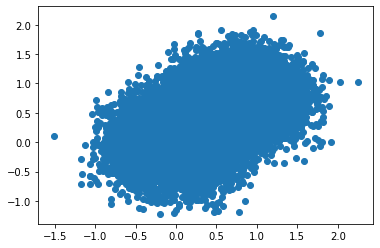

In [ ]:
blob_size = 10000
X, labels = make_blobs([blob_size, blob_size], centers=[[0,0],[0.75,0.75]], cluster_std=0.35, random_state=11)

plt.scatter(X[:,0], X[:,1])
plt.show()
P = np.ones((len(X),len(X)))
candidate_ind = np.arange(len(X))
batch_size = 4

In [ ]:
dist_metric='euclidean'
knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity=dist_metric)
W = gl.weightmatrix.knn(X, 25, kernel = 'distance', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)
print(G.isconnected())

t0 = timeit.default_timer()
centroids, sorted_points, E, num_iter = k_means_bal_randsample(G, candidate_ind, P, batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=0, time_info=False, knn_dist=None, energy_val=True)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

True
Time: 26.421201563000068  iteration: 12
[13177  4210 12254  5522]
4075
6561
5191
4173


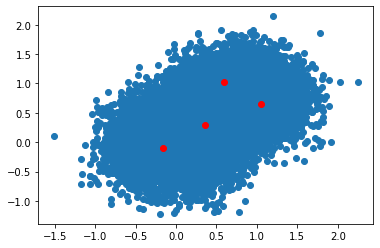

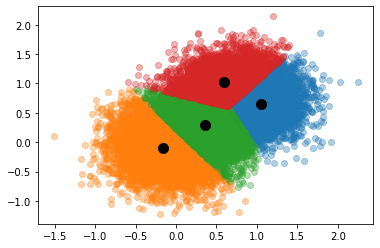

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
plt.show()

In [ ]:
dist_metric='angular'
knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity=dist_metric)
W = gl.weightmatrix.knn(X, 25, kernel = 'distance', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)
print(G.isconnected())

t0 = timeit.default_timer()
centroids, sorted_points, E, num_iter = k_means_bal_randsample(G, candidate_ind, P, batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=0, time_info=False, knn_dist=None, energy_val=True)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

True
Time: 118.21673881900006  iteration: 50
[ 1538 14570 12811 14819]
2524
2510
12291
2675


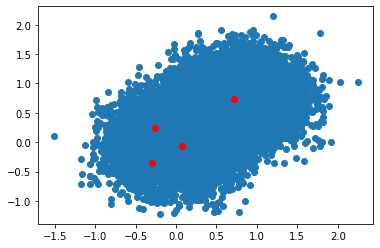

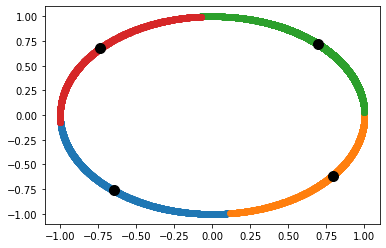

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
plt.show()

# GD Tests (Trivial P)

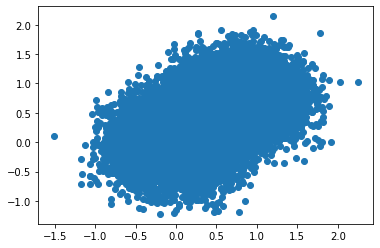

In [ ]:
blob_size = 10000
X, labels = make_blobs([blob_size, blob_size], centers=[[0,0],[0.75,0.75]], cluster_std=0.35, random_state=11)

plt.scatter(X[:,0], X[:,1])
plt.show()
P = np.ones((len(X),len(X)))
batch_size = 4

In [ ]:
dist_metric='euclidean'
# dist_metric='angular'

t0 = timeit.default_timer()
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, P, batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=0, solve_mtd='GD', time_info=False, alpha=1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 2.8613400909998745  iteration: 35
[14954 12788 16008  1024]
4924
5541
4861
4674


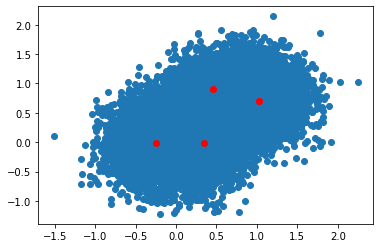

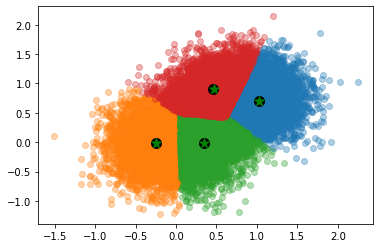

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids:
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

In [ ]:
# dist_metric='euclidean'
dist_metric='angular'

t0 = timeit.default_timer()
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, P, batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=0, solve_mtd='GD', time_info=False, alpha=1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 399.65370402700046  iteration: 50
[7174 4843 9101 3217]
2847
4263
10027
2863


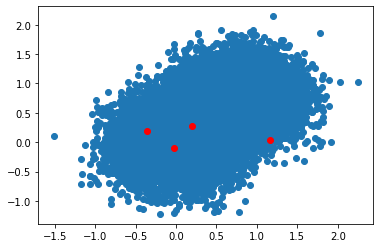

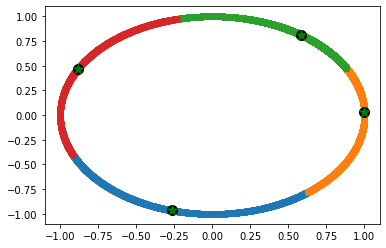

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids:
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

# Test on 3 blobs dataset (non-trivial weight)





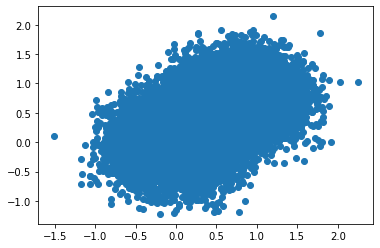

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Time Gradient Descent: 3.7704272609989857
Time Gradient Descent: 4.0687044090009294
Time Gradient Descent: 3.732145105001109
Time Gradient Descent: 0.210520231998089
Time Gradient Descent: 4.042416709999088
Time Gradient Descent: 0.2163394929993956
Time Gradient Descent: 3.730529692998971
Time Gradient Descent: 0.22118781100289198
Time Gradient Descent: 3.913138173000334
Time Gradient Descent: 0.22095554099723813
Time Gradient Descent: 3.73882485699869
Time Gradient Descent: 0.2165748959996563
Time Gradient Descent: 4.00311371099815
Time Gradient Descent: 0.2304225910011155
Time Gradient Descent: 3.7330185169994365
Time Gradient Descent: 0.21548271700157784
Time Gradient Descent: 4.624914062998869
Time Gradient Descent: 0.2195529919990804
Time Gradient Descent: 3.9468629060029343
Time Gradient Descent: 0.21384108499842114
Time Gradient Descent: 3.776288658998965
Time Gradient Descent: 0.20948199100166676
Time Gradient Descent: 3.986698084001546
Time Gradient Descent: 0.2132810490002157

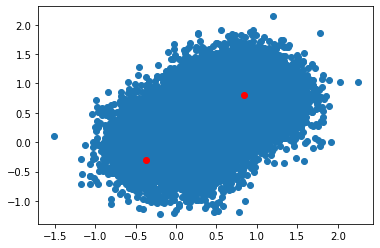

2


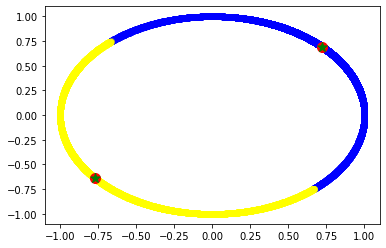

In [ ]:
blob_size = 10000
X, labels = make_blobs([blob_size, blob_size], centers=[[0,0],[0.75,0.75]], cluster_std=0.35, random_state=11)

batch_size = 2

# k_means_bal_experiment(X, batch_size, labels, max_iter=20, dist_metric='euclidean', weight_type = 4)
k_means_bal_experiment(X, batch_size, labels, max_iter=20, dist_metric='angular', weight_type = 4)

# Random Sample&GD

# Jeff's Example


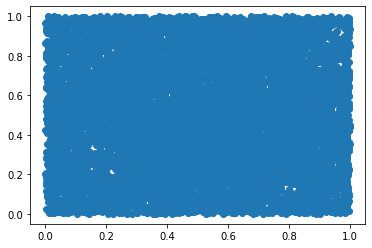

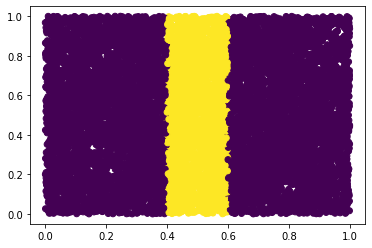

In [ ]:
blob_size = 10000

X = np.random.rand(blob_size, 2)

plt.scatter(X[:,0], X[:,1])
plt.show()
A = np.ones((1,len(X)))
A[:,np.absolute(X[:,0] -0.5) < 0.1] = 100
# P = np.ones((len(X),1))@(1/A**2)
batch_size = 5

plt.scatter(X[:,0], X[:,1], c=A)
plt.show()

In [ ]:
dist_metric='euclidean'
# dist_metric='angular'

t0 = timeit.default_timer()
# P = np.ones((len(X),len(X)))
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (5*A**0.7).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=2, solve_mtd='GD', time_info=False, alpha=0.1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))


Time: 1.8615672189999941  iteration: 13
[6622 3181 2499 2284 9734]
2319
1579
2110
1976
2016


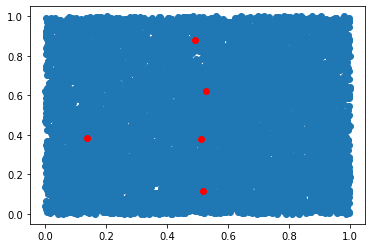

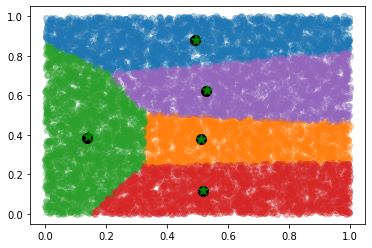

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids: 
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

In [ ]:
dist_metric='euclidean'
# dist_metric='angular'

t0 = timeit.default_timer()
# P = np.ones((len(X),len(X)))
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (A).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=20, solve_mtd='GD', time_info=False, alpha=0.1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))


Time: 4.406714179000119  iteration: 14
[9160 5661 4982 9655 5325]
2306
2286
1775
1626
2007


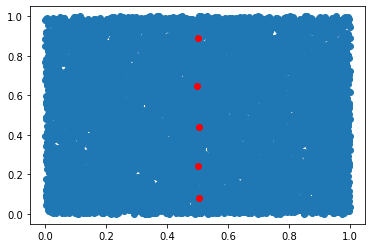

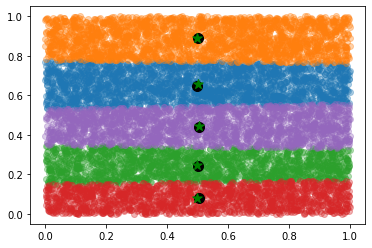

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids: 
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

In [ ]:
dist_metric='euclidean'
knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity=dist_metric)
W = gl.weightmatrix.knn(X, 25, kernel = 'distance', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)

candidate_ind = np.arange(len(X))

In [ ]:
t0 = timeit.default_timer()
centroids, sorted_points, E, num_iter = k_means_bal_randsample(G, X, (A**0.8).flatten(), batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=2, time_info=False, knn_dist=None, energy_val=True)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 4.599685456999964  iteration: 10
[5142 4603 6320 2693 3629]
2209
2122
1827
1707
2135


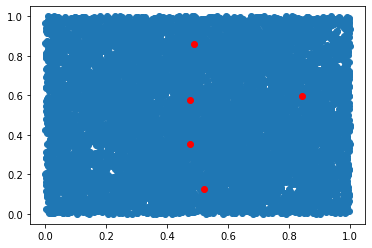

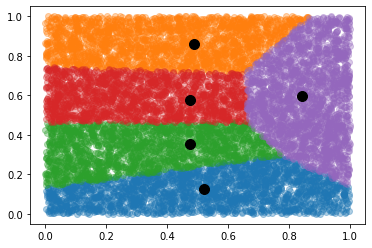

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
plt.show()

In [ ]:
t0 = timeit.default_timer()
centroids, sorted_points, E, num_iter = k_means_bal_randsample(G, X, (np.log(A+0.01)).flatten(), batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=2, time_info=False, knn_dist=None, energy_val=True)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 4.752194046  iteration: 10
[ 734 8222 9177 3617 2218]
2497
1877
1964
1567
2095


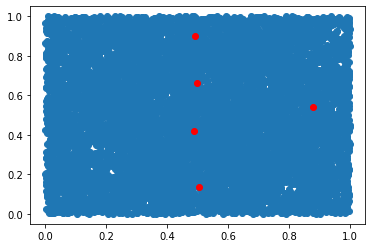

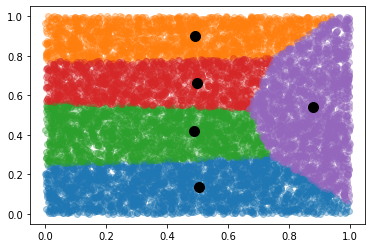

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
plt.show()

# Test on Circular Case

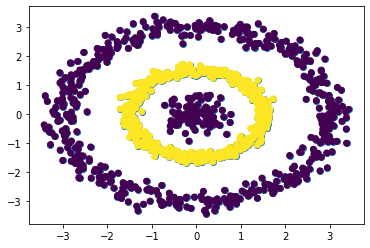

In [27]:
#Generate the circular dataset
#Yellow region is the ones with higher acq value

num_circle = 500
np.random.seed(0)
# num_circle = 501
theta = np.linspace(0, 2.*np.pi, num_circle)
r = 3.0

X_out = 3.0*np.array([np.cos(theta), np.sin(theta)]).T
X_out += 0.2*np.random.randn(*X_out.shape)
X_in = 1.5*np.array([np.cos(theta), np.sin(theta)]).T
X_in += 0.1*np.random.randn(*X_out.shape)

num_blobs = 100
X_blob, clustersb = make_blobs([num_blobs], centers=[[0,0]], cluster_std=0.35, random_state=11)

X = np.vstack((X_out, X_in, X_blob))
plt.scatter(X[:,0], X[:,1])

start_ind = len(X_out)
end_ind = len(X_out) + len(X_in)
A = np.ones((1,len(X)))
A[:,start_ind:end_ind] = 100

plt.scatter(X[:,0], X[:,1], c=A)
plt.show()

In [28]:
#Under this case, 5A^0.7 outperforms A
batch_size = 8
dist_metric='euclidean'
# dist_metric='angular'

t0 = timeit.default_timer()
# P = np.ones((len(X),len(X)))
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (A**0.8).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=20, solve_mtd='GD', time_info=False, alpha=0.1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 0.4933558920001815  iteration: 3
[474 777 561 859 671 961 109 303]
93
162
163
172
197
136
94
83


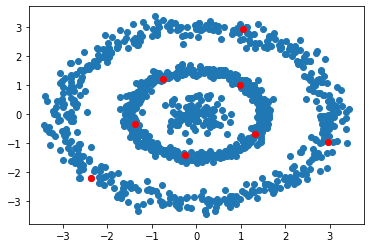

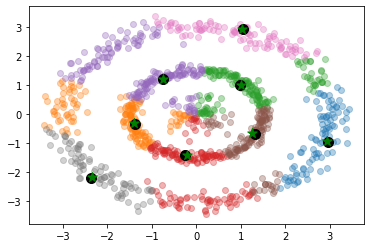

In [29]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids: 
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

In [ ]:
dist_metric='euclidean'
knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity=dist_metric)
W = gl.weightmatrix.knn(X, 25, kernel = 'distance', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)

candidate_ind = np.arange(len(X))

In [ ]:
batch_size=8
t0 = timeit.default_timer()
centroids, sorted_points, E, num_iter = k_means_bal_randsample(G, X, (A**0.7).flatten(), batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=20, time_info=False, knn_dist=None, energy_val=True)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 0.053104092000012315  iteration: 3
[462 774 561 847 670 961 132 295]
172
86
143
133
116
122
161
167


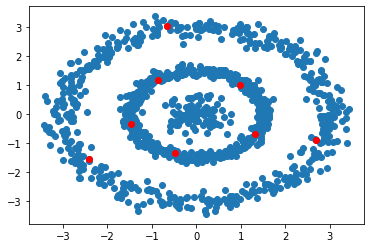

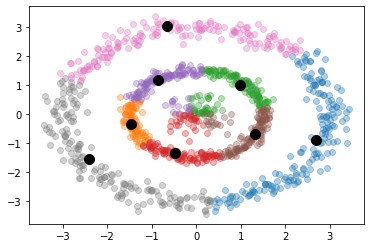

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
plt.show()

# Large and small blobs 

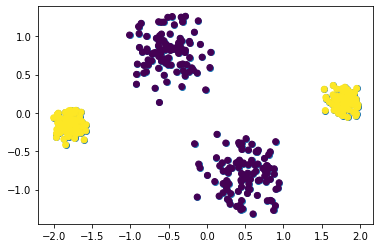

In [ ]:
#Generate the Blob sets
#Yellow region is the ones with higher acq value



blob_centers_1 = [[-0.5, 0.8], [0.5, -0.8]]
blob_centers_2 = [[-1.8, -0.15], [1.8, 0.15]]

num_blobs = 100
#Big blobs
X_blob_1, clusters_1 = make_blobs([num_blobs, num_blobs], centers=blob_centers_1, cluster_std=0.25, random_state=11)
#Small blobs
X_blob_2, clusters_2 = make_blobs([num_blobs, num_blobs], centers=blob_centers_2, cluster_std=0.1, random_state=11)

X = np.vstack((X_blob_1, X_blob_2))
plt.scatter(X[:,0], X[:,1])

start_ind = len(X_blob_1)
A = np.ones((1,len(X)))
A[:,start_ind:] = 100

plt.scatter(X[:,0], X[:,1], c=A)
plt.show()

In [ ]:
batch_size = 6
dist_metric='euclidean'
# dist_metric='angular'

t0 = timeit.default_timer()
# centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (np.log(A+0.001)).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
#                 randseed=2, solve_mtd='GD', time_info=False, alpha=0.1)
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (A**0.8).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=2, solve_mtd='GD', time_info=False, alpha=0.1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 0.3600694540000404  iteration: 2
[ 58 238 133 240 167 155]
99
100
39
100
25
37


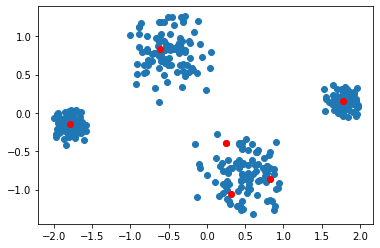

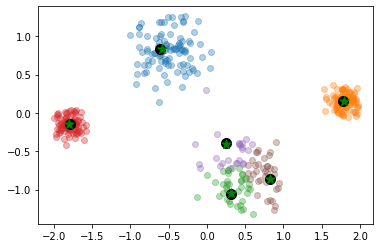

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':  
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids: 
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

In [ ]:
batch_size = 16
dist_metric='euclidean'
# dist_metric='angular'

t0 = timeit.default_timer()
# centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (np.log(A+0.001)).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
#                 randseed=2, solve_mtd='GD', time_info=False, alpha=0.1)
centroids, sorted_points, exact_centroids, E, num_iter = k_means_bal(X, (A**0.8).flatten(), batch_size, initial='k-means++', max_iter=50, dist_metric=dist_metric, 
                randseed=2, solve_mtd='GD', time_info=False, alpha=0.1)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 1.8316884630003187  iteration: 3
[168 222 317 100  65 133  46 277  52 225 273 123 119 197 188 126]
29
35
49
40
15
21
37
41
15
51
24
9
3
10
14
7


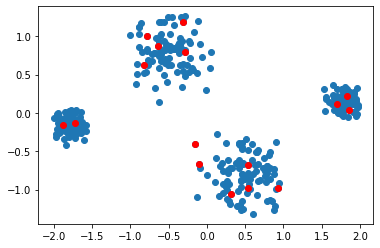

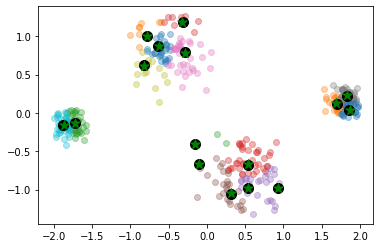

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':  
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
for p in exact_centroids: 
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)
plt.show()

In [ ]:
dist_metric='euclidean'
knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity=dist_metric)
W = gl.weightmatrix.knn(X, 25, kernel = 'distance', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)

candidate_ind = np.arange(len(X))

In [ ]:
batch_size=16
t0 = timeit.default_timer()
centroids, sorted_points, E, num_iter = k_means_bal_randsample(G, X, (A**0.7).flatten(), batch_size, sample_rate=0.05, initial='k-means++', max_iter=50, method='dijkstra', eik_p=1.0, tau=0.1,
                     ofs=0.2, q=1.0, randseed=20, time_info=False, knn_dist=None, energy_val=True)
print('Time:', timeit.default_timer()-t0, ' iteration:', num_iter)
print(centroids)
for i in range(batch_size):
    print(len(sorted_points[i]))

Time: 0.01942614700010381  iteration: 1
[355 351 139 147 104  65  46 130  91 258 248   9  80 103  59  44]
43
42
13
32
17
11
27
22
9
58
57
13
7
12
22
15


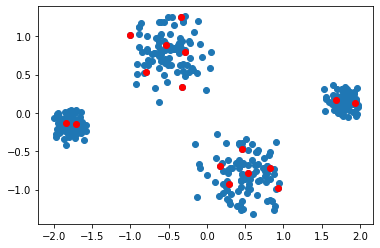

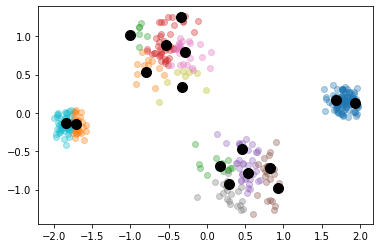

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
for i in range(len(sorted_points)):
    plt.scatter(Y[sorted_points[i],0], Y[sorted_points[i],1],  alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='black', marker='o', s=100)
plt.show()

# Dataset generation

In [ ]:
def gen_checkerboard_3(num_samples = 500, randseed = 123):
  np.random.seed(randseed)
  X = np.random.rand(num_samples, 2)
  labels = np.mod(np.floor(X[:, 0] * 3) + np.floor(X[:, 1] * 3), 3).astype(np.int64)

  return X, labels

In [ ]:
def gen_stripe_3(num_samples = 500, width = 1/3, randseed = 123):
  np.random.seed(randseed)
  X = np.random.rand(num_samples, 2)
  labels = np.mod(np.floor(X[:, 0] / width + X[:, 1] / width), 3).astype(np.int64)

  return X, labels

In [ ]:
from sklearn.datasets import make_blobs

def toy_dataset(num_circle=501, num_blobs=100):
    np.random.seed(0)
    # num_circle = 501
    theta = np.linspace(0, 2.*np.pi, num_circle)
    r = 3.0
    Xc = 3.0* np.array([np.cos(theta), np.sin(theta)]).T
    Xc += 0.1*np.random.randn(*Xc.shape)
    labelsc = np.zeros(num_circle)
    
    centersb = np.array([[1.75, 0.0],
                        [0.0, 1.75],
                        [-1.75, 0.0],
                        [0.0, -1.75]])
    Xb, clustersb = make_blobs([num_blobs, num_blobs, num_blobs, num_blobs], centers=centersb, cluster_std=0.35, random_state=11)
    labelsb = (clustersb % 2) + 1
    return np.vstack((Xc, Xb)), np.concatenate((labelsc, labelsb)).astype(int), np.concatenate((labelsc, clustersb + 1)).astype(int)

# Test on toy datasets ($log(ɛ+A_i)$)


## This is some function definitions. 
I think this shouldn't be its own function for now. It will probably be easier to compute in the actual thing. We just need to compute acquisition values once. Then we can construct it in place. 

In [ ]:
n_samples = 2000
#With 50000 samples it ran in 145 s
#Using uncertainty sampling gives more stringy outputs (less local maxima)

X,labels = gen_checkerboard_3(num_samples=n_samples)
# X,labels = gen_stripe_3(num_samples=n_samples, width=2/3)
# X, labels, _ = toy_dataset(1500,300)
# X,labels = datasets.make_moons(n_samples=n_samples,noise=0.1) 

knn_ind, knn_dist = gl.weightmatrix.knnsearch(X, 50, method='annoy', similarity='euclidean')
W = gl.weightmatrix.knn(X, 25, kernel = 'gaussian', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)

batch_size = 3

_, initial = _kmeans_plusplus(X, n_clusters=batch_size, random_state=check_random_state(123), x_squared_norms=None, n_local_trials=None)

In [ ]:
# coreset = coreset_dijkstras(G, rad = 0.2, DEBUGGING=False, data = X, initial=initial)
# coreset = initial

P = generate_matrix(X, W, initial, labels, weight_type=4)


In [ ]:
dist_metric='euclidean'
#dist_metric='angular'

centroids, sorted_points, exact_centroids, E, iteration = k_means_bal(X, P, batch_size, initial='k-means++', max_iter=20, dist_metric=dist_metric, 
                randseed=0, solve_mtd='GD', time_info=True, alpha=1, energy_val=False)
print(centroids)
print(len(sorted_points[0]))
print(len(sorted_points[1]))
print(len(sorted_points[2]))
# print(len(sorted_points[3]))

Time Gradient Descent: 0.0009383180004078895
Time Gradient Descent: 0.0007401850016321987
Time Gradient Descent: 0.00020244999905116856
Time Gradient Descent: 0.0008003570001164917
Time Gradient Descent: 0.0006752099980076309
Time Gradient Descent: 0.0003716489991347771
Time Gradient Descent: 0.0008600979999755509
Time Gradient Descent: 0.0005781180007033981
Time Gradient Descent: 0.00043504299901542254
Time Gradient Descent: 0.0007745530019747093
Time Gradient Descent: 0.001563095000165049
Time Gradient Descent: 0.0004616920014086645
[354 652 923]
784
604
612


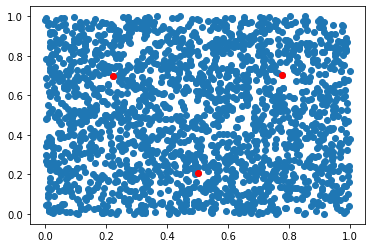

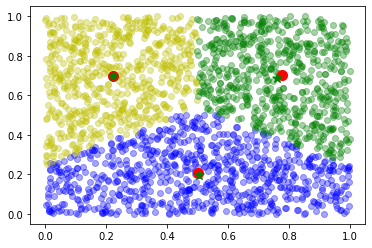

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[centroids ,0], X[centroids ,1], c='r')
plt.show()

if dist_metric == 'angular':
    Y = X /np.linalg.norm(X,axis=1)[:,None]
else:
    Y = X.copy()
plt.scatter(Y[sorted_points[0],0], Y[sorted_points[0],1], c='b', alpha=0.35)
plt.scatter(Y[sorted_points[1],0], Y[sorted_points[1],1], c='y', alpha=0.35)
plt.scatter(Y[sorted_points[2],0], Y[sorted_points[2],1], c='g', alpha=0.35)
# plt.scatter(Y[sorted_points[3],0], Y[sorted_points[3],1], c='orange', alpha=0.35)
plt.scatter(Y[centroids ,0], Y[centroids ,1], c='r', marker='o', s=100)
for p in exact_centroids:
    plt.scatter(p[0], p[1], marker='*', c='g', s=100)

plt.show()

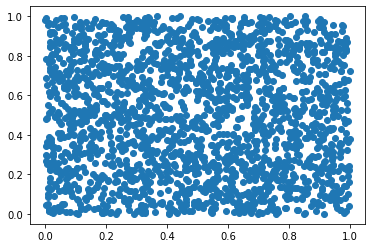

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Time Gradient Descent: 0.03120399500039639
Time Gradient Descent: 0.0312789800009341
Time Gradient Descent: 0.029161616999772377
Time Gradient Descent: 0.02439541000057943
Time Gradient Descent: 0.0004502890005824156
Time Gradient Descent: 0.00022170200099935755
Time Gradient Descent: 0.0003688450015033595
Time Gradient Descent: 0.020129974000155926
Time Gradient Descent: 0.0007466460010618903
Time Gradient Descent: 0.0005667999976139981
Time Gradient Descent: 0.0008325819981109817
Time Gradient Descent: 0.0010497780021978542
Time Gradient Descent: 0.0005766620015492663
Time Gradient Descent: 0.0007607070001540706
Time Gradient Descent: 0.0004536400010692887
Time Gradient Descent: 0.0006193720000737812
Time Gradient Descent: 0.0006943939988559578
Time Gradient Descent: 0.0004906929971184582
Time Gradient Descent: 0.0006772640008421149
Time Gradient Descent: 0.0013453790015773848
Time Gradient Descent: 0.0010152870017918758
Time Gradient Descent: 0.0007184590031101834
Time Gradient Desc

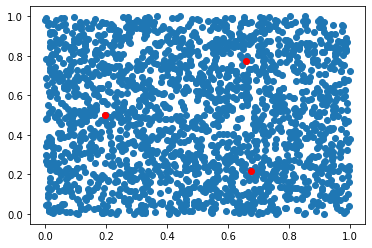

3


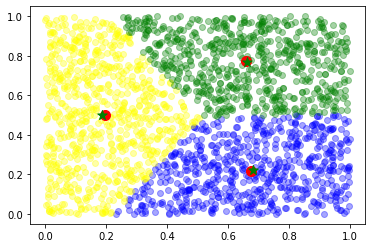

In [ ]:
X,labels = gen_checkerboard_3(num_samples=n_samples)
batch_size = 3

k_means_bal_experiment(X, batch_size, labels, dist_metric = 'euclidean', weight_type=4)
# k_means_bal_experiment(X, batch_size, labels, dist_metric = 'angular')

# Experiments on OpenSarShip


In [ ]:
#Load dataset
dataset_used = 'open_sar_ship'
_, labels = load_dataset(dataset_used, return_torch=False, concatenate=True)
encoded_data = encode_dataset('open_sar_ship', 'models/open_sar_ship_CNN.pt')
print(encoded_data.shape)

knn_ind, knn_dist = gl.weightmatrix.knnsearch(encoded_data, 50, method='annoy', similarity='euclidean')
W = gl.weightmatrix.knn(encoded_data, 25, kernel = 'gaussian', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)
initial = gl.trainsets.generate(labels, rate=1).tolist()

2296
About to start encoding
(2296, 4608)


In [ ]:
method = 'Laplace'
acq_fun = 'uc'

In [ ]:
coreset = coreset_dijkstras(G, rad = 0.35, DEBUGGING=False, data = encoded_data, initial=initial)

Active learning setup time =  2.1813990640000043


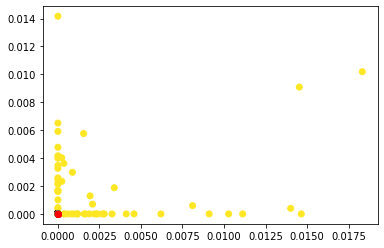

Size of coreset =  3
Using  0.13066202090592335 % of the data
Current Accuracy is  28.397212543554005 %
Batch Active Learning time =  1167.5989552659998


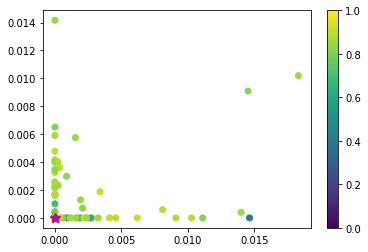

Model fit time =  0.3581227920001311
Next batch is [1624 1899   51  676 1001]
Current number of labeled nodes 8
Current Accuracy is  34.84320557491289 %


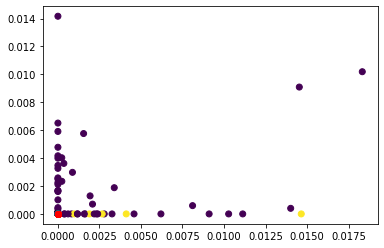

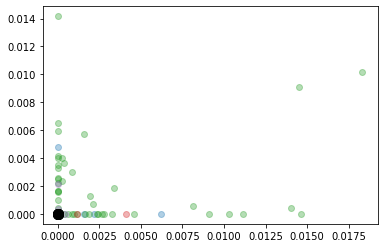

Iteration time =  1168.4050814739999
Batch Active Learning time =  1543.7871014529999


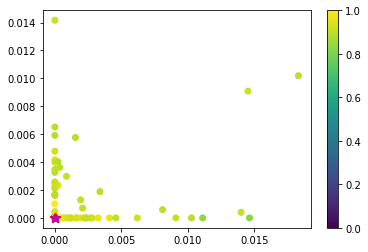

Model fit time =  0.3659916040001008
Next batch is [2259 1437 1328  663  996]
Current number of labeled nodes 13
Current Accuracy is  50.827526132404174 %


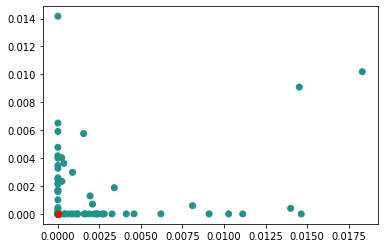

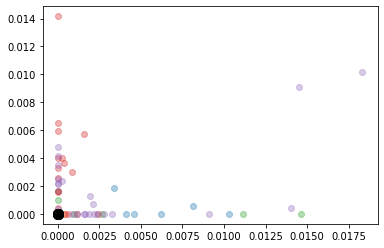

Iteration time =  1544.5561755780002
Batch Active Learning time =  951.2924172099997


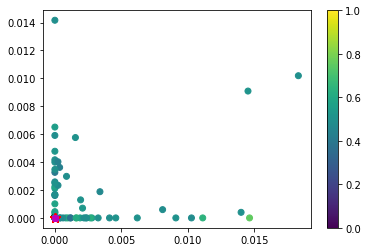

Model fit time =  0.3662934230001156
Next batch is [1663 1870  200  695 1801]
Current number of labeled nodes 18
Current Accuracy is  52.00348432055749 %


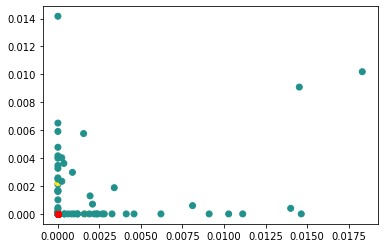

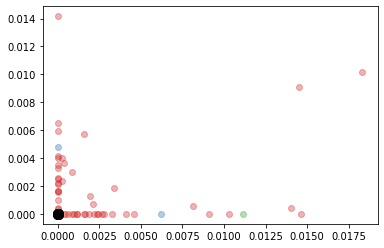

Iteration time =  952.0680274779997
Batch Active Learning time =  924.1235247319996


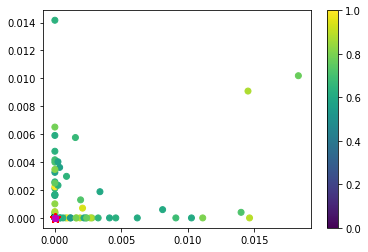

Model fit time =  0.3672533230001136
Next batch is [ 190 1022  852  991 1815]
Current number of labeled nodes 23
Current Accuracy is  58.0574912891986 %


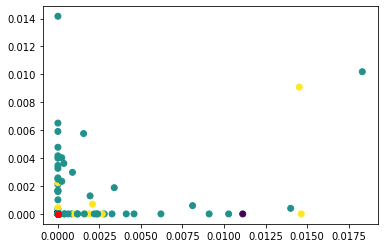

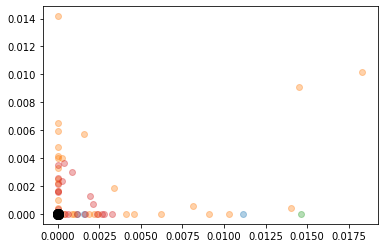

Iteration time =  924.9679376230001
Batch Active Learning time =  918.7552170509998


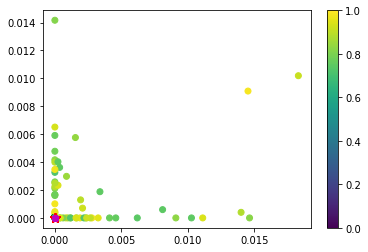

Model fit time =  0.3517701219998344
Next batch is [1975 1892 1857  981 1807]
Current number of labeled nodes 28
Current Accuracy is  53.963414634146346 %


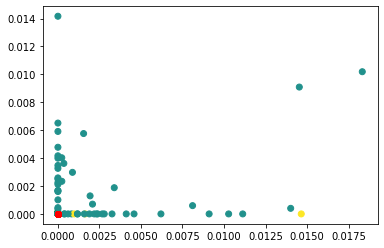

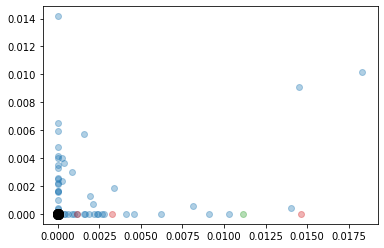

Iteration time =  919.5463668169996


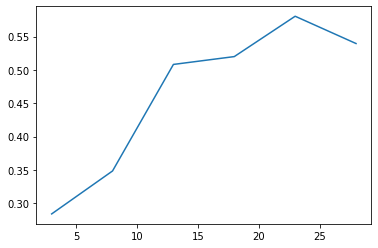

In [ ]:
new_samples = 10
labeled_ind1, list_num_labels1, list_acc1 = coreset_run_experiment(encoded_data, labels, W, coreset, num_iter=5, method='Laplace',
                           display=True, use_prior=False, al_mtd='gd_kmeans', debug=True,
                           acq_fun=acq_fun, knn_data=(knn_ind, knn_dist), mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=5,
                           dist_metric='euclidean', q=10, keep_top=False) 

#Running time: About 1h 30min 

In [ ]:
new_samples = 10

t0 = timeit.default_timer()
labeled_ind1, list_num_labels1, list_acc1 = coreset_run_experiment(encoded_data, labels,W, coreset, num_iter=5, method='Laplace',
                           display=True, use_prior=False, al_mtd='gd_kmeans', debug=True,
                           acq_fun=acq_fun, knn_data=(knn_ind, knn_dist), mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=15,
                           dist_metric='euclidean', q=10, keep_top=True)
print('Time:', timeit.default_timer()-t0)
#Running time: 1h

# Experiments on Fusar

In [ ]:
#Load dataset
dataset_used = 'fusar'
_, labels = load_dataset(dataset_used, return_torch=False, concatenate=True)
encoded_data, _ = encode_pretrained(dataset_used, 'ShuffleNet')
# encoded_data = encode_dataset(dataset_used, 'models/fusar_CNN.pt')
print(encoded_data.shape)

knn_ind, knn_dist = gl.weightmatrix.knnsearch(encoded_data, 50, method='annoy', similarity='euclidean')
W = gl.weightmatrix.knn(encoded_data, 25, kernel = 'gaussian', knn_data=(knn_ind, knn_dist))
G = gl.graph(W)
initial = gl.trainsets.generate(labels, rate=1).tolist()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(4856, 1024)


In [ ]:
method = 'Laplace'
acq_fun = 'uc'

In [ ]:
coreset = coreset_dijkstras(G, rad = 0.35, DEBUGGING=False, data = encoded_data, initial=initial)

Active learning setup time =  5.318628913999419


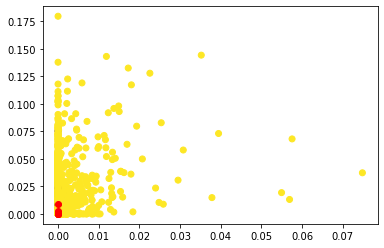

Size of coreset =  5
Using  0.10296540362438221 % of the data
Current Accuracy is  35.25535420098847 %
Batch Active Learning time =  742.52083709


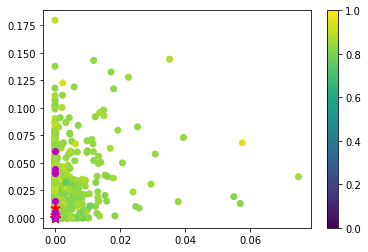

Model fit time =  0.4958364200001597
Next batch is [2734 1829  285 2348  350  735 3309 2494 2300 1578 1083 4720 1300  189
 4672]
Current number of labeled nodes 20
Current Accuracy is  44.62520593080725 %


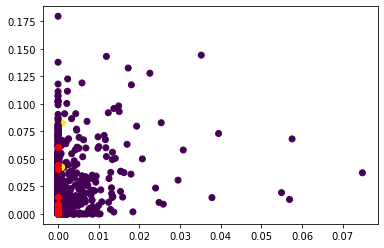

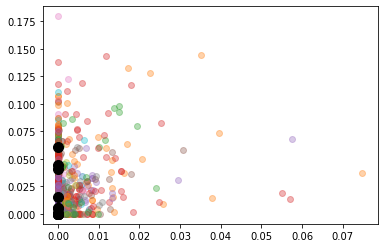

Iteration time =  743.5047650899996
Batch Active Learning time =  763.1398801509995


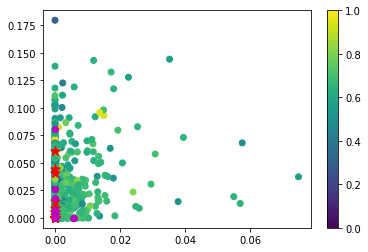

Model fit time =  0.48770589400010067
Next batch is [2746 4170 1827 1164 4095 1812 3302 3706  529 1064 2207 3001 1781 1626
 3097]
Current number of labeled nodes 35
Current Accuracy is  45.510708401976935 %


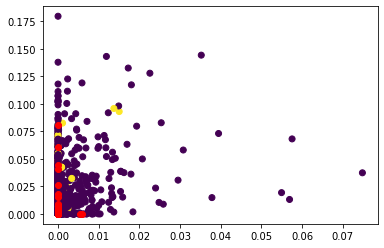

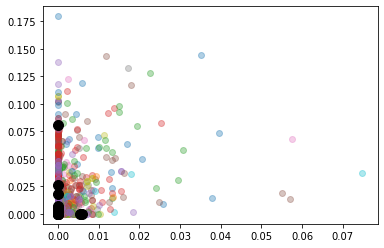

Iteration time =  764.1393206470002
Batch Active Learning time =  744.703589019


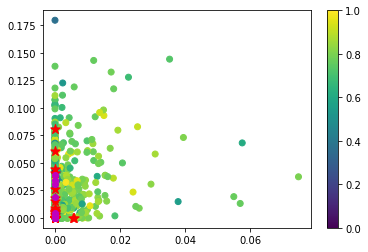

Model fit time =  0.49024696800006495
Next batch is [2343 4109 3030 1345 3154  702 3478   36  535  749 1746 2994 3181  186]
Current number of labeled nodes 49
Current Accuracy is  45.860790774299836 %


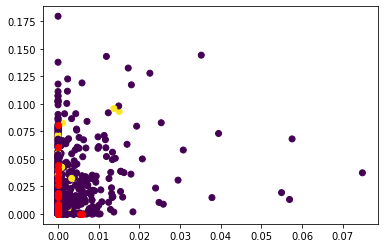

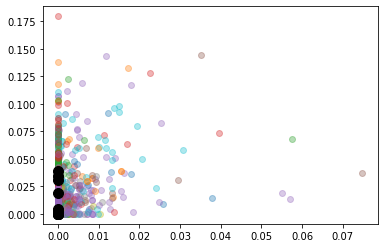

Iteration time =  745.6593340319996


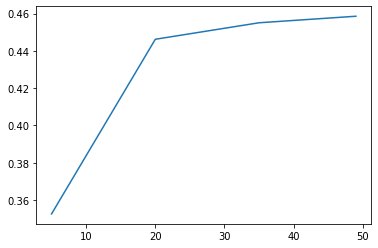

In [ ]:
new_samples = 10
labeled_ind1, list_num_labels1, list_acc1 = coreset_run_experiment(encoded_data, labels, W, coreset, num_iter=3, method='Laplace',
                           display=True, use_prior=False, al_mtd='gd_kmeans', debug=True,
                           acq_fun=acq_fun, knn_data=(knn_ind, knn_dist), mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=15,
                           dist_metric='euclidean', q=10, keep_top=True)